Adapted code from: https://gist.github.com/lmcinnes/7a39a9f103f25300aee07201bb0a9b8a

For vis: https://lmcinnes.github.io/datamapplot_examples/ArXiv_data_map_example.html

In [114]:
from dotenv import load_dotenv
import os

import numpy as np
import pandas as pd
# import datasets
import fast_hdbscan
import umap
import numba
import matplotlib.pyplot as plt

import sklearn .metrics
import vectorizers
import vectorizers.transformers
import sklearn.feature_extraction
import scipy.sparse

import sentence_transformers

from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import datamapplot
import colorcet as cc
import matplotlib

import tqdm
import string
from llama_cpp import Llama

In [115]:
# Get an API key from Anthropic AI and put it in a .env file in this directory.
# e.g.
# ANTHROPIC_API_KEY="sk-an...
load_dotenv()

True

# Building a map and clusters

In [116]:
embedding_model = sentence_transformers.SentenceTransformer("all-mpnet-base-v2", device="cuda")

In [117]:
dataset = pd.read_csv("./Search String H Results - Literature Reviews.csv", keep_default_na=False, na_values=[''])
dataset.drop_duplicates(subset=["Title"], inplace=True)
dataset = dataset[~(dataset["Manual Labelling"] == "N/A")]
dataset = dataset[(dataset["Unnamed: 41"] == "AI")]
dataset.reset_index(inplace=True)
dataset
# dataset.head()

,index,Unnamed: 0,Unnamed: 1,Unnamed: 2,Title,Year,Journal,Unnamed: 6,Unnamed: 7,Unnamed: 8,...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Manual Labelling,Zero-shot labelling (lower = more relevant),Relevant to Oceanography? (lower = more relevant),Unnamed: 41,Unnamed: 42,Notes / Comments,Include / Exclude
0,0,NaN,NaN,NaN,Comparative species abundance modeling of Capi...,2020,Marine Ecology Progress Series,NaN,NaN,NaN,...,NaN,NaN,NaN,Species distribution,Marine ecology (0.412); Plankton identificatio...,1.332103,AI,NaN,NaN,Included
1,1,Liu Y.; Meng Z.; Chen W.; Liang Y.; Chen W.; C...,"Liu, Yuyao (57240197700); Meng, Zhou (72018949...",57240197700; 7201894926; 57213686853; 57218294...,Ocean Fronts and Their Acoustic Effects: A Review,2022,Journal of Marine Science and Engineering,NaN,10,12,...,2-s2.0-85144836521,NaN,NaN,Acoustic classification,Acoustic classification (0.386); Sea floor map...,1.115355,AI,NaN,NaN,Included
2,2,Luo X.; Chen L.; Zhou H.; Cao H.,"Luo, Xinwei (36995012900); Chen, Lu (581222398...",36995012900; 58122239800; 58122239900; 5771425...,A Survey of Underwater Acoustic Target Recogni...,2023,Journal of Marine Science and Engineering,NaN,11,2,...,2-s2.0-85149119509,NaN,NaN,Acoustic classification,Acoustic classification (0.368); Detection of ...,1.355405,AI,NaN,NaN,Included
3,3,Zhufeng L.; Xiaofang L.; Na W.; Qingyang Z.,"Zhufeng, Lei (57201702161); Xiaofang, Lei (579...",57201702161; 57949172700; 57948807100; 5794892...,Present status and challenges of underwater ac...,2022,Frontiers in Physics,NaN,10,NaN,...,2-s2.0-85140965810,NaN,NaN,Acoustic classification,Acoustic classification (0.379); Contaminated ...,1.38632,AI,NaN,NaN,Included
4,4,NaN,NaN,NaN,Categorizing Shallow Marine Soundscapes Using ...,2023,Journal of Marine Science and Engineering,NaN,NaN,NaN,...,NaN,NaN,NaN,Acoustic classification,Acoustic classification (0.349); Marine ecolog...,1.151325,AI,NaN,NaN,Included
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,1616,NaN,NaN,NaN,Collaboration and engagement produce more acti...,2019,Ecological Applications,NaN,NaN,NaN,...,NaN,NaN,NaN,Species distribution,Marine ecology (0.416); Invasive species monit...,1.164338,AI,NaN,NaN,Included
891,1619,NaN,NaN,NaN,Exploring seafloor stretching in mariana trenc...,2019,"OCEANS 2019 - Marseille, OCEANS Marseille 2019",NaN,NaN,NaN,...,NaN,NaN,NaN,Sea floor mapping and bathymetry,Sea floor mapping and bathymetry (0.240); Coas...,1.161257,AI,NaN,NaN,Included
892,1622,NaN,NaN,NaN,Source apportionment using receptor model base...,2019,Atmospheric Environment,NaN,NaN,NaN,...,NaN,NaN,NaN,Ocean chemistry detection,Ocean chemistry detection (0.425); Contaminate...,1.652256,AI,NaN,NaN,Included
893,1624,NaN,NaN,NaN,Portable Imaging Flow-Cytometer Using Deep Lea...,2019,"2019 Conference on Lasers and Electro-Optics, ...",NaN,NaN,NaN,...,NaN,NaN,NaN,Underwater photography,Ocean chemistry detection (0.358); Contaminate...,1.293527,AI,NaN,NaN,Included


In [118]:
data_strings = pd.DataFrame(dataset)[["Title", "Abstract"]]

In [119]:
data_vectors = embedding_model.encode(data_strings.Title + "\n\n" + data_strings.Abstract, show_progress_bar=True)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

In [120]:
data_map = umap.UMAP(metric="cosine", n_components=2, random_state=42).fit_transform(data_vectors)

/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


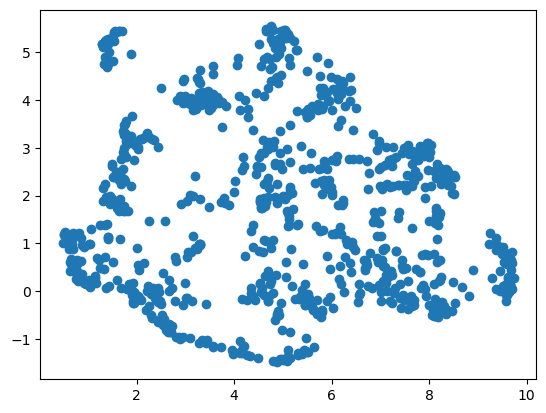

In [121]:
plt.scatter(*data_map.T)
plt.show()

Now we need to do some clustering; for this I'll use HDBCSAN (more specifically fast_hdbscan seeing as it is faster and more flexible at reaching into some of the internals). I want layers of clusters not a strict hierarchy, so we'll use some HDBSCAN based tricks to make that possible. I also want to keep track of a bunch of information which will then be used to feed back into the cluster naming -- the cluster centroid in the map layout; the cluster centroid in the original high-d embedding space; what the subclusters are; and the actual data points in each cluster.

After that we'll throw together some quick functions to get topical and distinctive sentences and extract keywords.

In [122]:
@numba.njit(fastmath=True)
def layer_from_clustering(
    point_vectors,
    point_locations,
    cluster_label_vector,
    cluster_membership_vector,
    base_clusters,
    membership_strength_threshold=0.2,
):
    n_clusters = len(set(cluster_label_vector)) - 1
    
    average_vectors = np.zeros((n_clusters, point_vectors.shape[1]), dtype=np.float32)
    average_locations = np.zeros((n_clusters, point_locations.shape[1]), dtype=np.float32)
    total_weights = np.zeros(n_clusters, dtype=np.float32)
    pointsets = [set([-1 for i in range(0)]) for i in range(n_clusters)]
    metaclusters = [set([-1 for i in range(0)]) for i in range(n_clusters)]

    for i in range(cluster_label_vector.shape[0]):
        cluster_num = cluster_label_vector[i]
        if cluster_num >= 0:
            average_vectors[cluster_num] += cluster_membership_vector[i] * point_vectors[i]
            average_locations[cluster_num] += cluster_membership_vector[i] * point_locations[i]
            total_weights[cluster_num] += cluster_membership_vector[i]
            
            if cluster_membership_vector[i] > membership_strength_threshold:
                pointsets[cluster_num].add(i)
                sub_cluster = base_clusters[i]
                if sub_cluster != -1:
                    metaclusters[cluster_num].add(sub_cluster)
                
    for c in range(n_clusters):
        average_vectors[c] /= total_weights[c]
        average_locations[c] /= total_weights[c]
        
    return average_vectors, average_locations, pointsets, metaclusters
                
            
def build_cluster_layers(
    point_vectors,
    point_locations,
    *,
    min_clusters=2,
    min_samples=5,
    base_min_cluster_size=10,
    membership_strength_threshold=0.2,
    next_cluster_size_quantile=0.8,
):
    vector_layers = []
    location_layers = []
    pointset_layers = []
    metacluster_layers = []
    
    min_cluster_size = base_min_cluster_size
    
    sklearn_tree = fast_hdbscan.hdbscan.KDTree(point_locations)
    numba_tree = fast_hdbscan.numba_kdtree.kdtree_to_numba(sklearn_tree)
    edges = fast_hdbscan.boruvka.parallel_boruvka(
        numba_tree, min_samples=min_cluster_size if min_samples is None else min_samples
    )
    sorted_mst = edges[np.argsort(edges.T[2])]
    uncondensed_tree = fast_hdbscan.cluster_trees.mst_to_linkage_tree(sorted_mst)
    new_tree = fast_hdbscan.cluster_trees.condense_tree(uncondensed_tree, base_min_cluster_size)
    leaves = fast_hdbscan.cluster_trees.extract_leaves(new_tree)
    clusters = fast_hdbscan.cluster_trees.get_cluster_label_vector(new_tree, leaves, 0.0)
    point_probs = fast_hdbscan.cluster_trees.get_point_membership_strength_vector(new_tree, leaves, clusters)


    cluster_ids = np.unique(clusters[clusters >= 0])
    base_clusters = clusters.copy()
    n_clusters_in_layer = cluster_ids.shape[0]
    
    base_layer = True

    while n_clusters_in_layer >= min_clusters:
        layer_vectors, layer_locations, layer_pointsets, layer_metaclusters = layer_from_clustering(
            point_vectors,
            point_locations,
            clusters,
            point_probs,
            base_clusters,
            membership_strength_threshold,            
        )
            
        if not base_layer:
            layer_metacluster_selection = np.asarray([len(x) > 1 for x in layer_metaclusters])
            layer_metaclusters = [
                list(x) for x, select in zip(layer_metaclusters, layer_metacluster_selection) if select
            ]
            layer_pointsets = [
                list(x) for x, select in zip(layer_pointsets, layer_metacluster_selection) if select
            ]
            layer_vectors = layer_vectors[layer_metacluster_selection]
            layer_locations=  layer_locations[layer_metacluster_selection]
            
        vector_layers.append(layer_vectors)
        location_layers.append(layer_locations)
        pointset_layers.append(layer_pointsets)
        metacluster_layers.append(layer_metaclusters)
        
        last_min_cluster_size = min_cluster_size
        min_cluster_size = int(np.quantile([len(x) for x in layer_pointsets], next_cluster_size_quantile))
        print(len(layer_vectors), last_min_cluster_size, min_cluster_size)
        
        new_tree = fast_hdbscan.cluster_trees.condense_tree(uncondensed_tree, min_cluster_size)
        leaves = fast_hdbscan.cluster_trees.extract_leaves(new_tree)
        clusters = fast_hdbscan.cluster_trees.get_cluster_label_vector(new_tree, leaves, 0.0)
        point_probs = fast_hdbscan.cluster_trees.get_point_membership_strength_vector(new_tree, leaves, clusters)
        
        cluster_ids = np.unique(clusters[clusters >= 0])
        n_clusters_in_layer = np.max(clusters) + 1
        base_layer = False
       
    pointset_layers = [[list(pointset) for pointset in layer] for layer in pointset_layers]
    return vector_layers, location_layers, pointset_layers, metacluster_layers


def diversify(query_vector, candidate_neighbor_vectors, alpha=1.0, max_candidates=16):
    distance_to_query = np.squeeze(sklearn.metrics.pairwise_distances(
        [query_vector], candidate_neighbor_vectors, metric="cosine")
    )
                                   
    retained_neighbor_indices = [0]
    for i, vector in enumerate(candidate_neighbor_vectors[1:], 1):
        retained_neighbor_distances = sklearn.metrics.pairwise_distances(
            [vector], candidate_neighbor_vectors[retained_neighbor_indices], metric="cosine"
        )[0]
        for j in range(retained_neighbor_distances.shape[0]):
            if alpha * distance_to_query[i] > retained_neighbor_distances[j]:
                break
        else:
            retained_neighbor_indices.append(i)
            if len(retained_neighbor_indices) >= max_candidates:
                return retained_neighbor_indices
            
    return retained_neighbor_indices


def topical_sentences_for_cluster(docs, vector_array, pointset, centroid_vector, n_sentence_examples=16):
    sentences = docs.values[pointset]

    sent_vectors = vector_array[pointset]
    candidate_neighbor_indices = np.argsort(
        np.squeeze(sklearn.metrics.pairwise_distances([centroid_vector], sent_vectors, metric="cosine"))
    )
    candidate_neighbors = sent_vectors[candidate_neighbor_indices]
    topical_sentence_indices = candidate_neighbor_indices[
        diversify(centroid_vector, candidate_neighbors)[:n_sentence_examples]
    ]
    topical_sentences = [sentences[i] for i in topical_sentence_indices]
    return topical_sentences

def distinctive_sentences_for_cluster(
    cluster_num, docs, vector_array, pointset_layer, cluster_neighbors, n_sentence_examples=16
):
    pointset = pointset_layer[cluster_num]
    sentences = docs.values[pointset]

    local_vectors = vector_array[sum([pointset_layer[x] for x in cluster_neighbors], [])]
    vectors_for_svd = normalize(local_vectors - local_vectors.mean(axis=0))
    U, S, Vh = randomized_svd(vectors_for_svd, 64)
    transformed_docs = (local_vectors @ Vh.T)
    transformed_docs = np.where(transformed_docs > 0, transformed_docs, 0)
    class_labels = np.repeat(
        np.arange(
            len(cluster_neighbors)
        ), 
        [len(pointset_layer[x]) for x in cluster_neighbors]
    )
    iwt = vectorizers.transformers.InformationWeightTransformer().fit(transformed_docs, class_labels)
    sentence_weights = np.sum(transformed_docs[:len(pointset)] * iwt.information_weights_, axis=1)
    distinctive_sentence_indices = np.argsort(sentence_weights)[:n_sentence_examples * 3]
    distinctive_sentence_vectors = vector_array[distinctive_sentence_indices]
    diversified_candidates = diversify(
        vector_array[pointset_layer[cluster_num]].mean(axis=0), 
        distinctive_sentence_vectors
    )
    distinctive_sentence_indices = distinctive_sentence_indices[diversified_candidates[:n_sentence_examples]]
    distinctive_sentences = [sentences[i] for i in distinctive_sentence_indices]
    return distinctive_sentences

def longest_keyphrases(candidate_keyphrases):
    result = []
    for i, phrase in enumerate(candidate_keyphrases):
        for other in candidate_keyphrases:
            if f" {phrase}" in other or f"{phrase} " in other:
                phrase = other
                
        if phrase not in result:
            candidate_keyphrases[i] = phrase
            result.append(phrase)
            
    return result

def contrastive_keywords_for_layer(
    full_count_matrix, 
    inverse_vocab, 
    pointset_layer, 
    doc_vectors, 
    vocab_vectors, 
    n_keywords=16, 
    prior_strength=0.1,
    weight_power=2.0
):
    count_matrix = full_count_matrix[sum(pointset_layer, []), :]
    column_mask = np.squeeze(np.asarray(count_matrix.sum(axis=0))) > 0.0
    count_matrix = count_matrix[:, column_mask]
    column_map = np.arange(full_count_matrix.shape[1])[column_mask]
    
    class_labels = np.repeat(np.arange(len(pointset_layer)), [len(x) for x in pointset_layer])
    iwt = vectorizers.transformers.InformationWeightTransformer(
        prior_strength=prior_strength, weight_power=weight_power
    ).fit(
        count_matrix, class_labels
    )
    count_matrix.data = np.log(count_matrix.data + 1)
    count_matrix.eliminate_zeros()
    
    weighted_matrix = iwt.transform(count_matrix)
    
    contrastive_keyword_layer = []
    
    from_row = 0
    for i in range(len(pointset_layer)):
        to_row = from_row + len(pointset_layer[i])
        contrastive_scores = np.squeeze(np.asarray(weighted_matrix[from_row:to_row].sum(axis=0)))
        contrastive_keyword_indices = np.argsort(contrastive_scores)[-4 * n_keywords:]
        contrastive_keywords = [inverse_vocab[column_map[j]] for j in reversed(contrastive_keyword_indices)]
        contrastive_keywords = longest_keyphrases(contrastive_keywords)
        
        centroid_vector = np.mean(doc_vectors[pointset_layer[i]], axis=0)
        keyword_vectors = np.asarray([vocab_vectors[word] for word in contrastive_keywords])
        chosen_indices = diversify(centroid_vector, keyword_vectors, alpha=0.66)[:n_keywords]
        contrastive_keywords = [contrastive_keywords[j] for j in chosen_indices]
        
        contrastive_keyword_layer.append(contrastive_keywords)
        from_row = to_row
        
    return contrastive_keyword_layer

So now we just cluster, picking a minimim base cluster size and let the choices of layering from there be decided by the algorithm. This does not take long.

# Clustering metrics

In [123]:
from tqdm.auto import trange

scs = []
chs = []
dbs = []
pos = []

for min_cluster_size in trange(2, 50):
    vector_layers, location_layers, pointset_layers, metacluster_layers = build_cluster_layers(
        data_vectors, data_map, base_min_cluster_size=min_cluster_size, min_clusters=4,
    )

    # ToDo: Drop outlier classes?
    int_labels = [-1] * len(data_vectors)
    for int_label, a in enumerate(pointset_layers[0]):
        for i in a:
            int_labels[i] = int_label

    # percent outliers
    int_labels = np.array(int_labels)
    inlier = int_labels >= 0
    outlier = int_labels == -1
    pos.append(sum(outlier)/len(int_labels))

    scs.append(silhouette_score(data_vectors, int_labels))
    chs.append(calinski_harabasz_score(data_vectors, int_labels))
    dbs.append(davies_bouldin_score(data_vectors, int_labels))

  0%|          | 0/48 [00:00<?, ?it/s]

70 2 10
23 10 28
13 28 67
5 67 179
54 3 15
14 15 45
10 45 77
4 77 245
52 4 16
16 16 46
10 46 77
4 77 245
50 5 17
15 17 46
10 46 77
4 77 245
48 6 18
13 18 46
10 46 77
4 77 245
42 7 19
12 19 61
6 61 164
38 8 21
12 21 67
5 67 179
33 9 27
10 27 70
4 70 245
30 10 28
10 28 70
4 70 245
28 11 28
9 28 73
4 73 245
27 12 28
9 28 73
4 73 245
24 13 31
9 31 86
4 86 245
24 14 31
9 31 86
4 86 245
24 15 31
9 31 86
4 86 245
22 16 44
7 44 104
21 17 45
7 45 104
20 18 46
6 46 113
17 19 56
5 56 114
16 20 62
5 62 167
15 21 66
4 66 195
14 22 66
4 66 195
14 23 66
4 66 195
14 24 66
4 66 195
14 25 66
4 66 195
14 26 66
4 66 195
14 27 66
4 66 195
13 28 67
4 67 195
12 29 67
3 67 211
12 30 67
3 67 211
12 31 67
3 67 211
12 32 67
3 67 211
12 33 67
3 67 211
11 34 68
3 68 211
11 35 68
3 68 211
11 36 68
3 68 211
11 37 68
3 68 211
11 38 68
3 68 211
11 39 68
3 68 211
11 40 68
3 68 211
11 41 68
3 68 211
11 42 68
3 68 211
11 43 68
3 68 211
10 44 77
3 77 247
10 45 77
3 77 247
10 46 77
3 77 247
9 47 105
8 48 107
8 49 107


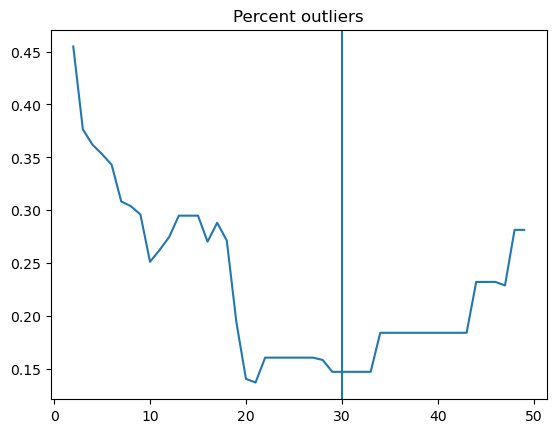

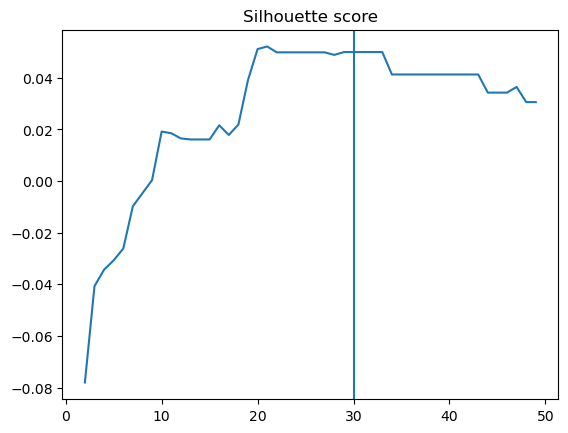

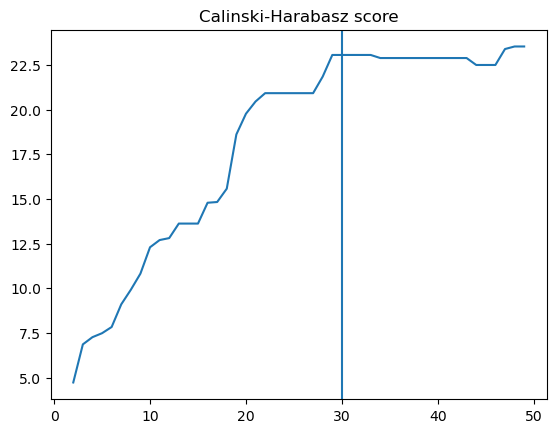

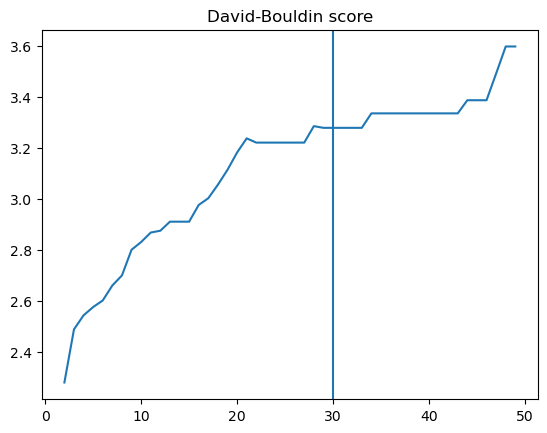

In [182]:
clusters = 30

plt.figure()
plt.plot(list(range(2, 50)), pos)
plt.axvline(clusters)
plt.title("Percent outliers")
plt.show()

plt.figure()
plt.plot(list(range(2, 50)), scs)
plt.axvline(clusters)
plt.title("Silhouette score")
plt.show()

plt.figure()
plt.plot(list(range(2, 50)), chs)
plt.axvline(clusters)
plt.title("Calinski-Harabasz score")
plt.show()

plt.figure()
plt.plot(list(range(2, 50)), dbs)
plt.axvline(clusters)
plt.title("David-Bouldin score")
plt.show()

# Cluster data

In [185]:
%%time
vector_layers, location_layers, pointset_layers, metacluster_layers = build_cluster_layers(
    data_vectors, data_map, base_min_cluster_size=clusters, min_clusters=5,
)
print(len(vector_layers[0]))

12 30 67
3 67 211
12
CPU times: user 8.42 ms, sys: 5.59 ms, total: 14 ms
Wall time: 4.49 ms


# Extracting useful cluster information for topic naming

Next I'm going to need a little more information, since for distinctive sentences (and later on as well) it will help to know what nearby clusters are. We could write something to do this efficiently, but there aren't that many clusters so we'll just brute-force the whole thing.

In [186]:
layer_cluster_neighbors = [
    np.argsort(
        sklearn.metrics.pairwise_distances(layer, metric="cosine"), 
        axis=1
    )[:, :16]
    for layer in vector_layers
]

Now we can generate topical sentences (sentences most similar to the cluster centroid, up to some diversification) and distinctive sentences (sentences that most strongly distinguish this cluster from nearby ones) for all the clusters.

In [187]:
%%time
topical_sentences_per_cluster = [
    [
        topical_sentences_for_cluster(data_strings["Title"], data_vectors, pointset, cluster_vector)
        for pointset, cluster_vector in zip(pointset_layers[i], vector_layers[i])
    ]
    for i in range(len(pointset_layers))
]

CPU times: user 877 ms, sys: 2.39 s, total: 3.26 s
Wall time: 183 ms


In [188]:
%%time
distinctive_sentences_per_cluster = [
    [
        distinctive_sentences_for_cluster(
            topic_num, data_strings["Title"], data_vectors, pointset_layers[i], layer_cluster_neighbors[i][topic_num]
        )
        for topic_num in range(len(pointset_layers[i]))
    ]
    for i in range(len(pointset_layers))
]

CPU times: user 20.6 s, sys: 38.2 s, total: 58.8 s
Wall time: 2.92 s


Next I'm going to want some keywords for each cluster. I'm just stealing from other similar code I wrote here, so please excuse the mess -- this was just a "get it done" effort. In essence this is really much the same as BERTopic's c-TF-IDF except it uses the slightly newer supervised information weighting instead c-IDF. It also helps to use a decent n-gram range and beef up the min_df to get more informative keywords.

In [189]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True, min_df=25, token_pattern='(?u)\\b\\w[-\'\\w]+\\b', ngram_range=(1,4))
full_count_matrix = cv.fit_transform(data_strings["Title"] + " " + data_strings["Abstract"])
acceptable_vocab = [v for v in cv.vocabulary_ if v.split()[0] not in sklearn.feature_extraction.text.ENGLISH_STOP_WORDS and v.split()[-1] not in sklearn.feature_extraction.text.ENGLISH_STOP_WORDS]
acceptable_indices = [cv.vocabulary_[v] for v in acceptable_vocab]
full_count_matrix = full_count_matrix[:, acceptable_indices]
inverse_vocab = {i:w for i, w in enumerate(acceptable_vocab)}
vocab = acceptable_vocab
len(vocab)

CPU times: user 987 ms, sys: 1.69 s, total: 2.68 s
Wall time: 465 ms


1049

In [190]:
vocab_vectors = dict(zip(vocab, embedding_model.encode(vocab, show_progress_bar=True)))

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

In [191]:
%%time
contrastive_keyword_layers = [
        contrastive_keywords_for_layer(
        full_count_matrix, 
        inverse_vocab, 
        pointset_layers[layer_num], 
        data_vectors,
        vocab_vectors,
    )
    for layer_num in range(len(pointset_layers))
]

CPU times: user 748 ms, sys: 1.63 s, total: 2.38 s
Wall time: 160 ms


# Naming the lowest layer of topics

Now we get to the point of using an LLM to create topic names. I went through a few iterations of things like this, and this is what the prompt generation evolved into; if I was starting from scratch I think we could write this much more cleanly. Still, it gets the job done.

In [192]:
def create_prompt(
    i, 
    contrastive_keyword_layer=contrastive_keyword_layers[0], 
    topical_sentences_per_cluster=topical_sentences_per_cluster[0],
    distinctive_sentences_per_cluster=distinctive_sentences_per_cluster[0],
    base_cluster_neighbors=layer_cluster_neighbors[0],
):
    prompt_text = "--\n\nBelow is a information about a group of titles from machine learning articles:\n\n"
    prompt_text += "Distinguishing keywords for this group:\n - \"" + ", ".join(contrastive_keyword_layer[i]) + "\"\n"
    prompt_text += "\nSample topical titles from the group include:\n"
    for text in topical_sentences_per_cluster[i]:
        prompt_text += f" - \"{text}\"\n"
    prompt_text += "\nSample distinctive titles from the group include:\n"
    for text in distinctive_sentences_per_cluster[i]:
        prompt_text += f" - \"{text}\"\n"

    prompt_text += "\n\nSimilar titles from different groups with distinct topics include:\n"
    for n in base_cluster_neighbors[i][:3]:
        for text in distinctive_sentences_per_cluster[n][:2]:
            prompt_text += f"- \"{text}\"\n"

    prompt_text += "\n\nThe short distinguishing topic name for the group that had the keywords:\n - \"" + ", ".join(contrastive_keyword_layer[i][:8]) + "\" \n"
    prompt_text += "is:\n"
    return prompt_text

In [193]:
import anthropic

client = anthropic.Anthropic()

# Duplicate Llama api for calling
def llm(prompt, max_tokens=16, temperature=0.8):
    message = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=max_tokens,
        temperature=temperature,
        system="Give terse category names for the questions asked. Do not provide explanations for your responses. Make sure each topic name is sufficiently distinct from other topic groups.",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    }
                ]
            }
        ]
    )
    return message

Now we need out LLM. A quantized version of Mistral 7B is not bad, but pick the model that works for you. If you have a GPU this goes a lot faster. If you have a big GPU you will probably want a better model. In general the most powerful model that you can run on the hardware you have is likely your best bet.

In [194]:
# !wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/QuantFactory/Meta-Llama-3-8B-Instruct-GGUF/resolve/main/Meta-Llama-3-8B-Instruct.Q4_K_M.gguf
# !wget https://huggingface.co/QuantFactory/Meta-Llama-3-70B-Instruct-GGUF/resolve/main/Meta-Llama-3-70B-Instruct.Q4_K_M.gguf

In [195]:
# llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)
# llm = Llama(model_path="Meta-Llama-3-8B-Instruct.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)
# llm = Llama(model_path="Meta-Llama-3-70B-Instruct.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)
# llm()

Before we run this in earnest let's try it out on the first cluster to make sure it works.

In [196]:
llm(create_prompt(0), max_tokens=24, temperature=0.75)

Message(id='msg_019in3exxUGQs8KrXvTx5SY6', content=[ContentBlock(text='Arctic Sea Ice Monitoring', type='text')], model='claude-3-opus-20240229', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=857, output_tokens=8))

Looks good enough. Obviously we'll need to clean up the output a little, but that's easy enough to add. Let's write a function to do the naming ...

In [197]:
def base_level_topic_names(
    topical_sentence_layer,
    distinctive_sentence_layer,
    contrastive_keyword_layer,
    base_cluster_neighbors,
    from_topic_index=0,
    to_topic_index=10,
):
    topic_names = []
    for i in tqdm.notebook.tqdm(range(from_topic_index, to_topic_index)):
        topic_naming_prompt = create_prompt(
            i, 
            contrastive_keyword_layer=contrastive_keyword_layer, 
            topical_sentences_per_cluster=topical_sentence_layer,
            distinctive_sentences_per_cluster=distinctive_sentence_layer,
            base_cluster_neighbors=base_cluster_neighbors,
        )
        topic_name = llm(topic_naming_prompt).content[0].text
        if "\n" in topic_name:
            topic_name = topic_name.lstrip("\n ")
            topic_name = topic_name.split("\n")[0]
        topic_name = string.capwords(topic_name.strip(string.punctuation + string.whitespace))
        topic_names.append(topic_name)

    return topic_names

And away we go ...



In [198]:
%%time
layer0_topics = base_level_topic_names(
    topical_sentences_per_cluster[0],
    distinctive_sentences_per_cluster[0],
    contrastive_keyword_layers[0],
    layer_cluster_neighbors[0],
    to_topic_index=len(contrastive_keyword_layers[0])
)

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 38 ms, sys: 1.74 ms, total: 39.7 ms
Wall time: 32.2 s


In [199]:
layer0_topics

['Arctic Sea Ice Monitoring',
 'Marine Bioacoustics',
 'Marine Biogeochemistry',
 'Ocean Color Remote Sensing',
 'Coastal Ecosystem Mapping',
 'Ocean And Climate Modeling',
 'Marine Ecology Modeling',
 'Coastal Water Quality Prediction',
 'Hurricane And Coastal Flood Risk',
 'Ocean Dynamics Modeling',
 'Oil Spill & Marine Debris Detection',
 'Automated Marine Imagery Analysis']

# Naming all the other layers of topics

Now we have the other layers to deal with. Since these are larger clusters it is harder to get representative sentences that cover the full breadth and still fit in the prompt context size. However we did keep track of sub-clusters and now we have names for all those sub-clusters, so we can provide that instead. Of course if there are too many sub-clusters that can be tricky as well. So pick out the topical sub-topic names and distinctive sub-topic names (with a large selection) -- we just need to embed all the cluster names we've got so far.

In [200]:
embeddings_of_layer0_topics = embedding_model.encode(layer0_topics, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [201]:
def topical_subtopics_for_cluster(
    metacluster, pointset, doc_vectors, base_layer_topic_names, base_layer_pointsets, n_subtopics=32
):
    centroid_vector = np.mean(doc_vectors[pointset], axis=0)
    subtopic_vectors = np.asarray([np.mean(doc_vectors[base_layer_pointsets[n]], axis=0) for n in metacluster])
    candidate_neighbor_indices = np.argsort(
        np.squeeze(sklearn.metrics.pairwise_distances([centroid_vector], subtopic_vectors, metric="cosine"))
    )[:2 * n_subtopics]
    candidate_neighbors = subtopic_vectors[candidate_neighbor_indices]
    topical_subtopic_indices = candidate_neighbor_indices[
        diversify(centroid_vector, candidate_neighbors, alpha=0.66, max_candidates=n_subtopics)
    ][:n_subtopics]
    topical_subtopics = [base_layer_topic_names[metacluster[i]] for i in topical_subtopic_indices]
    return topical_subtopics


def contrastive_subtopics_for_cluster(
    cluster_neighbors, meta_clusters, base_layer_topic_embeddings, base_layer_topic_names, n_subtopics=24
):
    topic_names = [base_layer_topic_names[x] for x in meta_clusters[cluster_neighbors[0]]]
    local_vectors = base_layer_topic_embeddings[sum([meta_clusters[x] for x in cluster_neighbors], [])]
    U, S, Vh = np.linalg.svd(local_vectors - local_vectors.mean(axis=0))
    transformed_docs = (local_vectors @ Vh.T)
    transformed_docs = np.where(transformed_docs > 0, transformed_docs, 0)
    class_labels = np.repeat(np.arange(len(cluster_neighbors)), [len(meta_clusters[x]) for x in cluster_neighbors])
    iwt = vectorizers.transformers.InformationWeightTransformer().fit(transformed_docs, class_labels)
    topic_name_weights = np.sum(transformed_docs[:len(topic_names)] * iwt.information_weights_, axis=1)
    distinctive_topic_indices = np.argsort(topic_name_weights)[:n_subtopics * 3]
    distinctive_topic_vectors = base_layer_topic_embeddings[distinctive_topic_indices]
    diversified_candidates = diversify(
        base_layer_topic_embeddings[meta_clusters[cluster_neighbors[0]]].mean(axis=0), 
        distinctive_topic_vectors
    )
    distinctive_topic_indices = distinctive_topic_indices[diversified_candidates[:n_subtopics]]
    distinctive_sentences = [topic_names[i] for i in distinctive_topic_indices]
    return distinctive_sentences

Now we just need to build that information for all the layers and clusters ...

In [202]:
%%time
topical_subtopic_layers = [
    [
        topical_subtopics_for_cluster(
            metacluster_layers[layer_num][cluster_num],
            pointset_layers[layer_num][cluster_num],
            data_vectors,
            layer0_topics,
            pointset_layers[0],
            n_subtopics=32
        )
        for cluster_num in range(len(metacluster_layers[layer_num]))
    ]
    for layer_num in range(1, len(metacluster_layers))
]

CPU times: user 0 ns, sys: 3.29 ms, total: 3.29 ms
Wall time: 2.96 ms


In [203]:
%%time
contrastive_subtopic_layers = [
    [
        contrastive_subtopics_for_cluster(
            layer_cluster_neighbors[layer_num][cluster_num],
            metacluster_layers[layer_num],
            embeddings_of_layer0_topics,
            layer0_topics,
            n_subtopics=24
        )
        for cluster_num in range(len(metacluster_layers[layer_num]))
    ]
    for layer_num in range(1, len(metacluster_layers))
]

CPU times: user 500 ms, sys: 1.32 s, total: 1.82 s
Wall time: 85.7 ms


/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:254: RuntimeWarning: invalid value encountered in power
  self.information_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(


Given that we are using the sub-topic names we need a different prompt construction.

In [204]:
def create_prompt_from_subtopics(
    i,
    contrastive_keyword_layer,
    subtopic_layer,
    topical_sentences_layer,
    distinctive_sentences_layer,
    cluster_neighbors
):
    prompt_text = "--\n\nBelow is a information about a group of titles from machine learning articles that are all on the same topic:\n\n"
    prompt_text += "Distinguishing keywords for this group: \"" + ", ".join(contrastive_keyword_layer[i]) + "\"\n"
    prompt_text += "Sample sub-topics from the group include:\n"
    for text in subtopic_layer[i][:24]:
        prompt_text += f"- \"{text}\"\n"
    prompt_text += "Sample topical titles include:\n"
    for text in topical_sentences_layer[i][:4]:
        prompt_text += f"- \"{text}\"\n"
    prompt_text += "Sample distinctive titles of the topic include:\n"
    for text in distinctive_sentences_layer[i][:4]:
        prompt_text += f"- \"{text}\"\n"        
    

    prompt_text += "\n\nSimilar titles from different groups with distinct topics include:\n"
    for n in cluster_neighbors[i][:3]:
        for text in topical_sentences_layer[n][:2]:
            prompt_text += f"- \"{text}\"\n"
    prompt_text += "\nSub-topics from different but similar groups include:\n"
    for n in cluster_neighbors[i][:3]:
        for text in subtopic_layer[n][:4]:
            prompt_text += f"- \"{text}\"\n"    
            
    prompt_text += "\n\nThe short distinguishing topic name for the group that had the keywords \"" + ", ".join(contrastive_keyword_layer[i]) + "\" "
    prompt_text += "is:"
    return prompt_text

Then we just need a function for do all the naming and clean uip the output names ...

In [205]:
def subtopics_and_keywords_to_topic_name(
    subtopics_layer,
    contrastive_keyword_layer,
    topical_sentences_layer,
    distinctive_sentences_layer,
    cluster_neighbors,
    from_topic_index=0,
    to_topic_index=10,
):
    topic_names = []
    for i in tqdm.notebook.tqdm(range(from_topic_index, to_topic_index)):
        topic_naming_prompt = create_prompt_from_subtopics(
            i, 
            contrastive_keyword_layer, 
            subtopics_layer,
            topical_sentences_layer,
            distinctive_sentences_layer,
            cluster_neighbors,
        )
        topic_name = llm(topic_naming_prompt).content[0].text
        if "\n" in topic_name:
            topic_name = topic_name.lstrip("\n ")
            topic_name = topic_name.split("\n")[0]
        topic_name = string.capwords(topic_name.strip(string.punctuation + string.whitespace))

        topic_names.append(topic_name)

    return topic_names

And we can start naming topics for the other layers ...

In [206]:
%%time
layer1_topics = subtopics_and_keywords_to_topic_name(
    [a + b for a,b in zip(topical_subtopic_layers[0], contrastive_subtopic_layers[0])],
    contrastive_keyword_layers[1],
    topical_sentences_per_cluster[1],
    distinctive_sentences_per_cluster[1],
    layer_cluster_neighbors[1],
    from_topic_index=0,
    to_topic_index=len(topical_subtopic_layers[0]),
)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 383 ms, sys: 1.43 s, total: 1.81 s
Wall time: 7.64 s


In [207]:
%%time
layer2_topics = subtopics_and_keywords_to_topic_name(
    [a + b for a,b in zip(topical_subtopic_layers[1], contrastive_subtopic_layers[1])],
    contrastive_keyword_layers[2],
    topical_sentences_per_cluster[2],
    distinctive_sentences_per_cluster[2],
    layer_cluster_neighbors[2],
    from_topic_index=0,
    to_topic_index=len(topical_subtopic_layers[1]),
)

IndexError: list index out of range

In [100]:
%%time
layer3_topics = subtopics_and_keywords_to_topic_name(
    [a + b for a,b in zip(topical_subtopic_layers[2], contrastive_subtopic_layers[2])],
    contrastive_keyword_layers[3],
    topical_sentences_per_cluster[3],
    distinctive_sentences_per_cluster[3],
    layer_cluster_neighbors[3],
    from_topic_index=0,
    to_topic_index=len(topical_subtopic_layers[2]),
)

IndexError: list index out of range

The last problem that tends to occur is that we end up repeating topic names, particulary having high level topic names get repeated at lower levels where we want something more specific. But we can lookmfor those cases and try to get the LLM to generate a more specific topic name.

In [210]:
def create_final_remedy_prompt(original_topic_names, docs, vector_array, pointset, centroid_vector):
    sentences = topical_sentences_for_cluster(docs, vector_array, pointset, centroid_vector, n_sentence_examples=64)
    prompt_text = "A set of titles from machine learning articles was described as having a topic of one of " + ", ".join(original_topic_names) + ".\n"
    prompt_text += "These topic names were not specific enough and were shared with other different but similar groups of titles.\n"
    prompt_text += "A sampling of titles from this specific set of titles includes:\n"
    for sentence in np.random.choice(sentences, size=min(len(sentences), 64), replace=False):
        prompt_text += f"- {sentence}\n"

    prompt_text += f"\n\nThe current name for this topic of these paragraphs is: {original_topic_names[-1]}\n"
    prompt_text += "A better and more specific name that still captures the topic of these article titles is: "
    return prompt_text

In [212]:
all_layer_topics = [layer0_topics, layer1_topics,] #layer2_topics]#, layer3_topics]

In [213]:
all_layer_topics

[['Arctic Sea Ice Monitoring',
  'Marine Bioacoustics',
  'Marine Biogeochemistry',
  'Ocean Color Remote Sensing',
  'Coastal Ecosystem Mapping',
  'Ocean And Climate Modeling',
  'Marine Ecology Modeling',
  'Coastal Water Quality Prediction',
  'Hurricane And Coastal Flood Risk',
  'Ocean Dynamics Modeling',
  'Oil Spill & Marine Debris Detection',
  'Automated Marine Imagery Analysis'],
 ['Satellite Ocean Biogeochemistry',
  'Maritime Hazard Forecasting',
  'Marine Ecosystem Monitoring']]

In [214]:
from tqdm.auto import trange

And now we just go through the layers and fix up topic names; generating the topic label vectors suitable for input directly into [DataMapPlot](https://github.com/TutteInstitute/datamapplot):

In [215]:
%%time
layer_clusters = [np.full(data_map.shape[0], "Unlabelled", dtype=object) for i in range(len(all_layer_topics))]
unique_names = set([])

for n in range(len(all_layer_topics) - 1, -1, -1):
    print(f"Working on layer {n}")
    for i, (name, indices) in enumerate(zip(all_layer_topics[n], pointset_layers[n])):
        if i % 100 == 0:
            print(f"Working on cluster {i}")
        n_attempts = 0
        recapped_name = string.capwords(name.strip(string.punctuation + string.whitespace))
        unique_name = recapped_name
        original_topic_names = [unique_name]
        while unique_name in unique_names and n_attempts < 8:
            prompt_text = create_final_remedy_prompt(
                original_topic_names, data_strings["Title"], data_vectors, indices, vector_layers[n][i]
            )
            unique_name = llm(prompt_text, max_tokens=36).content[0].text
            if "\n" in unique_name:
                unique_name = unique_name.lstrip("\n ")
                unique_name = unique_name.split("\n")[0]
            unique_name = string.capwords(unique_name.strip(string.punctuation + string.whitespace))
            original_topic_names.append(unique_name)
            n_attempts += 1
        if n_attempts > 0:
            print(f"{name} --> {unique_name} after {n_attempts} attempts")
        unique_names.add(unique_name)
        layer_clusters[n][indices] = unique_name

Working on layer 1
Working on cluster 0
Working on layer 0
Working on cluster 0
CPU times: user 0 ns, sys: 1.01 ms, total: 1.01 ms
Wall time: 2.3 ms


A quick glance at the topic names generated for the two uppermost layers shows we mostly did a decent job. Obviously with a little more care we could do a lot better, but for something essentially entirely auotmated this is not so bad. At worst you can go in an clean up some of the topic names by hand.

In [216]:
all_layer_topics[-1]

['Satellite Ocean Biogeochemistry',
 'Maritime Hazard Forecasting',
 'Marine Ecosystem Monitoring']

In [217]:
all_layer_topics[-2]

['Arctic Sea Ice Monitoring',
 'Marine Bioacoustics',
 'Marine Biogeochemistry',
 'Ocean Color Remote Sensing',
 'Coastal Ecosystem Mapping',
 'Ocean And Climate Modeling',
 'Marine Ecology Modeling',
 'Coastal Water Quality Prediction',
 'Hurricane And Coastal Flood Risk',
 'Ocean Dynamics Modeling',
 'Oil Spill & Marine Debris Detection',
 'Automated Marine Imagery Analysis']

# Create an interactive plot and save as HTML

In [219]:
plot = datamapplot.create_interactive_plot(
    data_map,
    layer_clusters[0],
    layer_clusters[1],
    # layer_clusters[2],
    # layer_clusters[3],
    # font_family="Cinzel",
    font_family="Playfair Display SC",
    cluster_boundary_polygons=False,
    # cluster_boundary_line_width=6,
    title="Oceanography Papers Using Machine Learning",
    sub_title="Embeddings of titles and abstracts for papers using machine learning for oceanographic research",
    enable_search=True,
    darkmode=False,
    use_medoids=True,
    color_label_text=True,
    # inline_data=False,
    # offline_data_prefix="bb-ai-1",
    on_click="window.open(`http://google.com/search?q=\"{hover_text}\"`)",
    # cmap=matplotlib.colormaps.get_cmap("cet_glasbey"),
    min_fontsize=20,
    max_fontsize=64,
    # marker_size_array=[len(x) for x in dataset['Title']],
    # point_radius_min_pixels=1,
    # point_radius_max_pixels=18,
    hover_text=dataset['Title'],
)
plot

<InteractiveFigure width=100% height=800>

In [220]:
plot.save("index.html")

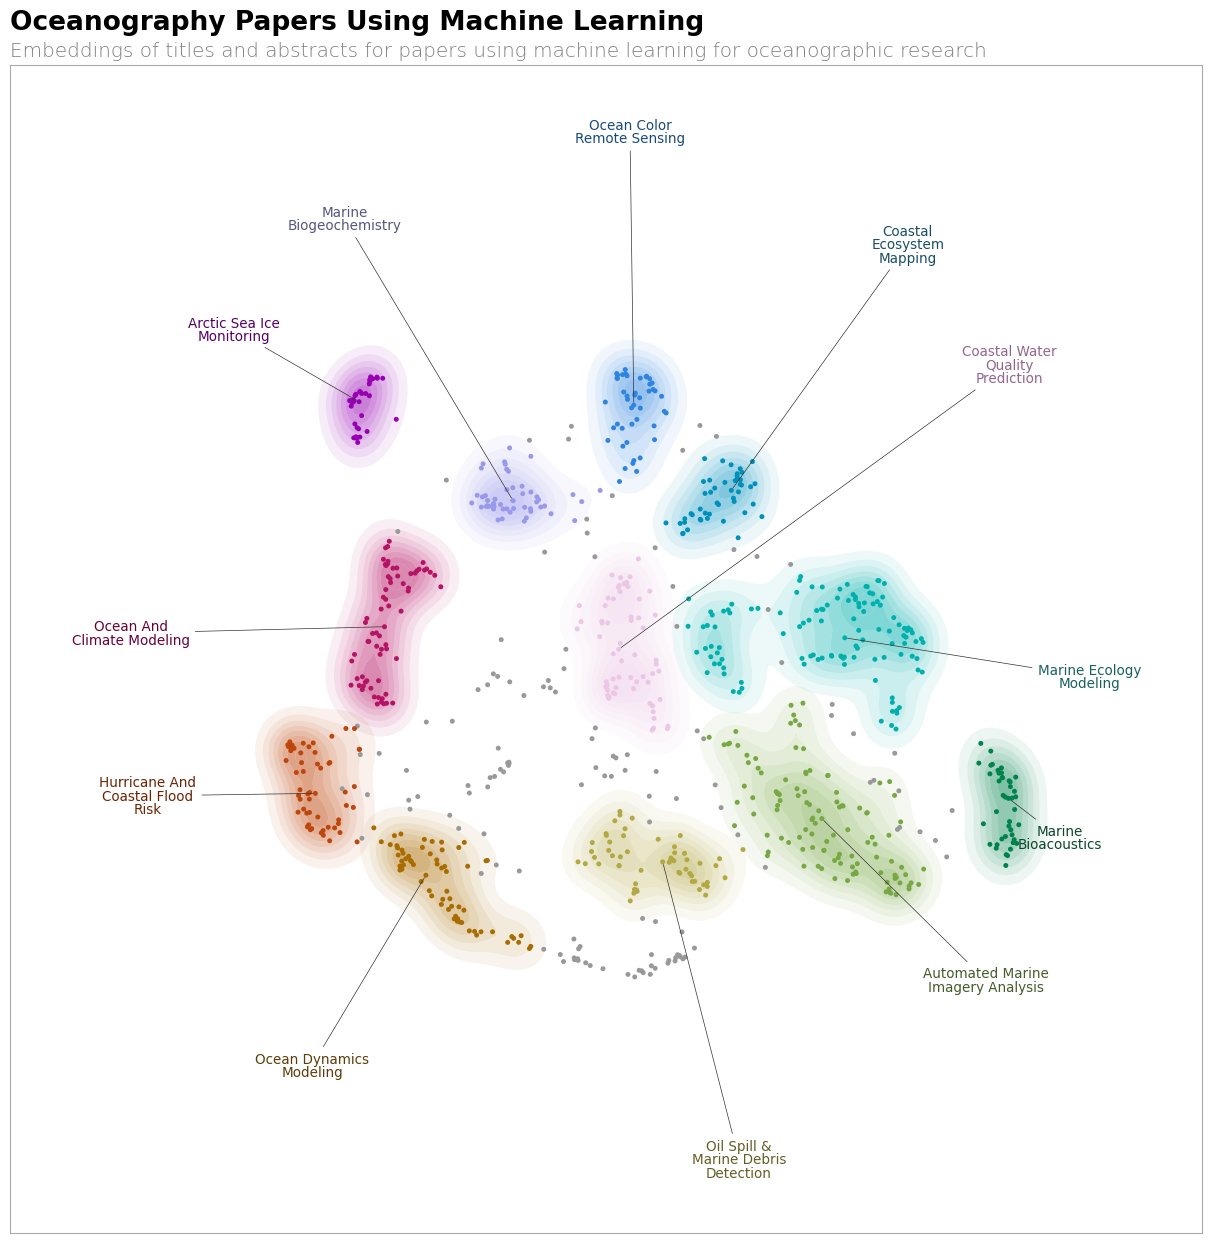

In [221]:
# Static visualization
fig, ax = datamapplot.create_plot(
    data_map,
    layer_clusters[0],
    title="Oceanography Papers Using Machine Learning",
    sub_title="Embeddings of titles and abstracts for papers using machine learning for oceanographic research",
    darkmode=False,
    use_medoids=True,
    # label_font_size=11,
    # label_wrap_width=10,
)

In [222]:
fig.savefig("oceanography-ml-landscape.png", bbox_inches="tight")

# Export XLSX

In [229]:
clusters_df = pd.DataFrame(dataset[["Title", "Abstract"]])
clusters_df

,Title,Abstract
0,Comparative species abundance modeling of Capi...,Capitellid polychaetes are ubiquitous througho...
1,Ocean Fronts and Their Acoustic Effects: A Review,As one of the widespread physical phenomena in...
2,A Survey of Underwater Acoustic Target Recogni...,Underwater acoustic target recognition (UATR) ...
3,Present status and challenges of underwater ac...,Future naval warfare has placed high demands o...
4,Categorizing Shallow Marine Soundscapes Using ...,Natural marine soundscapes are being threatene...
...,...,...
890,Collaboration and engagement produce more acti...,Aquatic telemetry technology generates new kno...
891,Exploring seafloor stretching in mariana trenc...,Multibeam bathymetry data could represent near...
892,Source apportionment using receptor model base...,Source apportionment studies have been perform...
893,Portable Imaging Flow-Cytometer Using Deep Lea...,We demonstrate deep learning assisted holograp...


In [230]:
clusters_df["Topic"] = layer_clusters[0]
clusters_df["MetaTopic"] = layer_clusters[1]
# clusters_df["SuperSuperTopic"] = layer_clusters[2]

clusters_df.sort_values(["Topic", "MetaTopic"], inplace=True)

clusters_df

,Title,Abstract,Topic,MetaTopic
92,Space-based Earth observation in support of th...,"Space-based Earth observation (EO), in the for...",Arctic Sea Ice Monitoring,Unlabelled
283,Sea ice surface type classification of ICESat-...,The ICESat-2 (IS2) ATL07 sea ice height produc...,Arctic Sea Ice Monitoring,Unlabelled
284,Deep Learning of Systematic Sea Ice Model Erro...,Data assimilation is often viewed as a framewo...,Arctic Sea Ice Monitoring,Unlabelled
285,AutoTerm: An automated pipeline for glacier te...,Ice sheet marine margins via outlet glaciers a...,Arctic Sea Ice Monitoring,Unlabelled
286,Sea Ice Extent Prediction with Machine Learnin...,The decline of sea ice in the Arctic region is...,Arctic Sea Ice Monitoring,Unlabelled
...,...,...,...,...
840,Feature engineering and forecasting via deriva...,This study introduces a framework for the fore...,Unlabelled,Unlabelled
845,Hydro-Morphological Characterization of Coral ...,Many coral reef-lined coasts are low-lying wit...,Unlabelled,Unlabelled
868,Prediction of groundwater level in seashore re...,It is challenging to predict groundwater level...,Unlabelled,Unlabelled
880,Sediment identification using machine learning...,Machine learning classifiers have been rarely ...,Unlabelled,Unlabelled


In [231]:
clusters_df.to_excel("Topic_Results.xlsx")